<a href="https://colab.research.google.com/github/liatico/SuperResolution/blob/main/deep_learning_assingment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import tarfile
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Add, UpSampling2D, LeakyReLU, Activation, add, concatenate, ReLU
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import activations
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import tensorflow as tf
from PIL import Image
import io
import skimage
from tensorflow.keras.callbacks import Callback
import imageio
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import shutil
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50
import timeit
from sklearn.metrics import mean_squared_error

import and load data

In [ ]:


IMAGE_PATH = "VOCdevkit/VOC2007/JPEGImages"

if not os.path.isdir('data'):
  
  data = requests.get("http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar")
  with open("data.tar", 'wb') as f:
      f.write(data.content) 

  tar = tarfile.open("data.tar")
  tar.extractall()
  tar.close()




In [ ]:
path = '/content/VOCdevkit/VOC2007/JPEGImages/'
filelist = glob.glob(path+'*.jpg')
x_train, x_test = train_test_split(filelist, test_size=0.1)

custom data generator that returns one input image of (72,72,3) and two output images (144,144,3) and (288,288,3) 

In [ ]:
def generate_data(filelist, batch_size):
  
  j=0
  while True:
    x = []
    y_mid = []
    y_large = []
    for i in range(batch_size):
      if j < len(filelist):
        f = filelist[j]
        j += 1
        img = cv2.imread(f)/255.
        x.append(cv2.resize(img,(72,72)))
        y_mid.append(cv2.resize(img,(144,144)))
        y_large.append(cv2.resize(img,(288,288)))
      else:
        j = 0
    x = np.array(x); y_mid = np.array(y_mid); y_large = np.array(y_large)
    yield x, (y_mid, y_large) 


train function

In [ ]:
def train_model(model, epochs=40, batch_size=32, idx=0):
  start = timeit.default_timer()
  img_for_gif = cv2.imread(x_train[idx])/255.
  img_for_gif = cv2.resize(img_for_gif,(72,72))
  gif_callback = make_gif_callback(img_for_gif, model.name)
  steps = len(x_train)/batch_size
  history = model.fit(generate_data(filelist=x_train, batch_size=batch_size), callbacks=[gif_callback], epochs=epochs, steps_per_epoch=steps)
  print("train run time: {} s".format(timeit.default_timer()-start))
  plot_history(history)
  return model

plot graphs and train history function

In [ ]:
def plot_history(history):
  fig, ax = plt.subplots(1, 2, figsize=(15,6))
  train_psnr = np.array(history.history['loss']) * -1
  mid_psnr = np.array(history.history['out_mid_psnr'])
  larg_psnr = np.array(history.history['out_large_psnr'])
  ax[0].plot(train_psnr, label="train PSNR")
  ax[0].plot(mid_psnr, label="mid PSNR")
  ax[0].plot(larg_psnr, label="large PSNR")
  ax[0].set_title('PSNR')
  ax[0].legend(loc="upper left")
  ax[1].plot(history.history['out_mid_mse'], label="mid MSE")
  ax[1].plot(history.history['out_large_mse'], label="large MSE")
  ax[1].set_title('MSE')
  ax[1].legend(loc="upper left")
  fig.suptitle("matrics for train")
  plt.show()
  print("train mean MSE for mid image: {:.3f}".format(np.mean(history.history['out_mid_mse'])))
  print("train mean MSE for large image: {:.3f}".format(np.mean(history.history['out_large_mse'])))
  print("train mean PSNR for mid image: {:.3f}".format(np.mean(mid_psnr)))
  print("train mean PSNR for large image: {:.3f}".format(np.mean(larg_psnr)))
  print("train mean PSNR: {:.3f}".format(np.mean(train_psnr)))

predict on test set and show results function

In [ ]:
def predict_and_show_results(model, test_set, index):
  x = []
  y_mid = []
  y_large = []
  for f in test_set:
    img = cv2.imread(f)/255.
    x.append(cv2.resize(img,(72,72)))
    y_mid.append(cv2.resize(img,(144,144)))
    y_large.append(cv2.resize(img,(288,288)))
  x = np.array(x); y_mid = np.array(y_mid); y_large = np.array(y_large)
  pred_1,pred_2 = model.predict(x)
  plot_images(index, x, y_mid, pred_1)
  plot_images(index, x, y_large, pred_2)

  mid_mse = np.square(np.subtract(y_mid,pred_1)).mean()
  large_mse = np.square(np.subtract(y_large,pred_2)).mean()

  mid_psnr = tf.image.psnr(y_mid,pred_1, max_val=1)
  large_psnr = tf.image.psnr(y_large,pred_2, max_val=1)
  print("mean PSNR for mid images: {:.3f}\nmean PSNR for large images: {:.3f}\n".format(np.mean(mid_psnr), np.mean(large_psnr)))
  print("mean MSE for mid images: {:.3f}\nmean MSE for large images: {:.3f}\n".format(np.mean(mid_mse), np.mean(large_mse)))
  fig, ax1 = plt.subplots(1, 1, )
  ax1.plot(mid_psnr)
  ax1.plot(large_psnr)
  fig.suptitle("psnr of predictions")
  # ax[0].show()

In [ ]:

def plot_images(i, x , y_mid, y_large):
  fig, ax = plt.subplots(1, 3, figsize=(20,6))
  ax[0].imshow(x[i])
  ax[1].imshow(y_mid[i])
  ax[2].imshow(y_large[i])


add a custom callback that creates plots of one of the validation images over the epochs – to visually exemplify the improvements achieved during the convergence process. You may (but not have to) create a gif that shows the aggregation of these plots as an animation

In [ ]:

class make_gif_callback(Callback):
    def __init__(self, image, name):
        super().__init__() 
        self.image = image
        self.name = name
        self.mid = []
        self.large = []

    def on_epoch_end(self, epoch, logs={}):
      mid_im, large_im = self.model.predict(np.array([self.image]))
      mid_im = mid_im[0]*255
      mid_im = mid_im.astype('uint8')
      self.mid.append(mid_im)
      large_im = large_im[0]*255
      large_im = large_im.astype('uint8')
      self.large.append(large_im)

    def on_train_end(self, logs=None):
      imageio.mimwrite('mid_image_{}.gif'.format(self.name), self.mid, fps=1)
      imageio.mimwrite('large_image_{}.gif'.format(self.name), self.large, fps=1)


psnr matric

In [ ]:
def psnr(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1)

psnr loss function, which returns -psnr, because psnr should be maximised and loss is minimized

In [ ]:
def psnr_loss(y_true, y_pred):
  return -tf.image.psnr(y_true, y_pred, max_val=1)

Create an initial model
In this step, create an initial fully convolutional model with the following architecture. add another block to your model so that you’ll have both 144x144x3 output along with 288x288x3 output as follows:
(make sure you understand the dimensions in each step of the process)

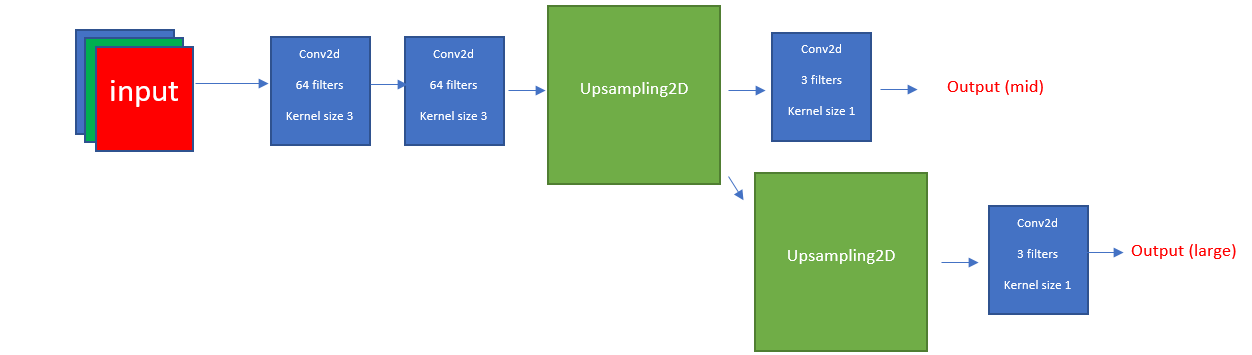


In [ ]:

def create_basic_model():
  input = Input(shape=(None,None,3))
  mid = Conv2D(64, (3, 3), padding="same", activation="relu")(input)
  mid = Conv2D(64, (3, 3), padding="same", activation="relu")(mid)
  mid = UpSampling2D(size=2, interpolation='bilinear')(mid)
  large = UpSampling2D(size=2, interpolation='bilinear')(mid)
  large = Conv2D(3, (1, 1), padding="same", activation="sigmoid",name='out_large')(large)
  mid = Conv2D(3, (1, 1), padding="same", activation="sigmoid", name='out_mid')(mid)
  model = Model(input, [mid,large], name='basic_model')
  model.compile(optimizer=Adam(0.01), loss=psnr_loss, metrics=[psnr, 'mse'])
  return model
 

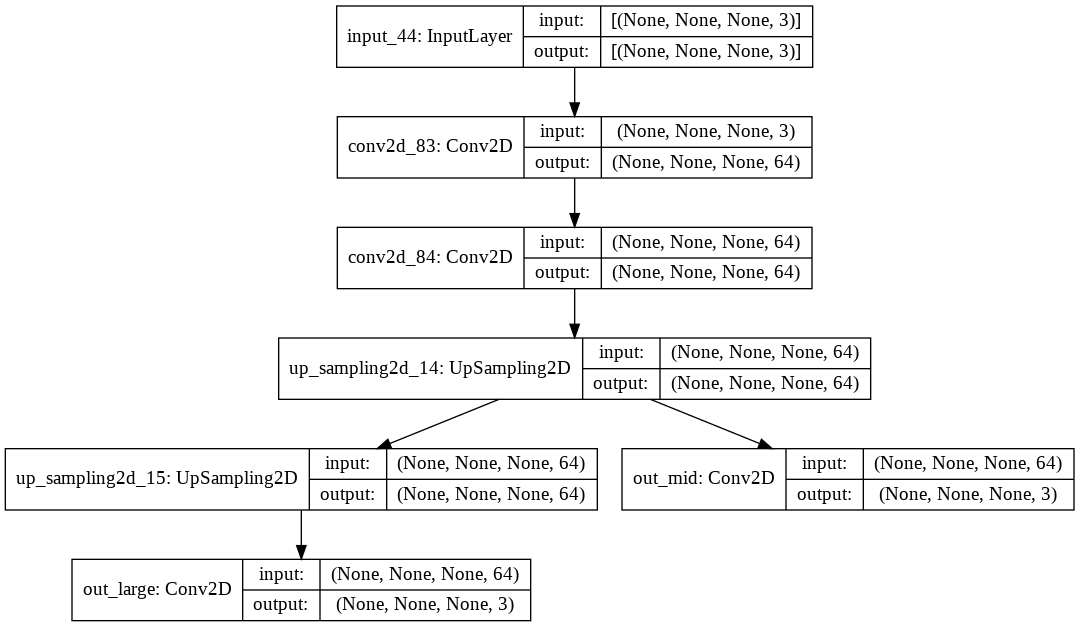

In [ ]:
model = create_basic_model()
plot_model(model, show_shapes=True, show_layer_names=True)

Epoch 1/20
140/140 [==============================] - 43s 246ms/step - loss: -35.9872 - out_mid_loss: -17.9789 - out_large_loss: -18.0084 - out_mid_psnr: 17.9789 - out_mid_mse: 0.0259 - out_large_psnr: 18.0084 - out_large_mse: 0.0258
Epoch 2/20
140/140 [==============================] - 34s 243ms/step - loss: -44.6915 - out_mid_loss: -22.2615 - out_large_loss: -22.4300 - out_mid_psnr: 22.2615 - out_mid_mse: 0.0073 - out_large_psnr: 22.4300 - out_large_mse: 0.0070
Epoch 3/20
140/140 [==============================] - 34s 244ms/step - loss: -45.2293 - out_mid_loss: -22.5146 - out_large_loss: -22.7147 - out_mid_psnr: 22.5146 - out_mid_mse: 0.0070 - out_large_psnr: 22.7147 - out_large_mse: 0.0067
Epoch 4/20
140/140 [==============================] - 34s 242ms/step - loss: -45.2734 - out_mid_loss: -22.5323 - out_large_loss: -22.7411 - out_mid_psnr: 22.5323 - out_mid_mse: 0.0070 - out_large_psnr: 22.7411 - out_large_mse: 0.0066
Epoch 5/20
140/140 [==============================] - 34s 245ms/

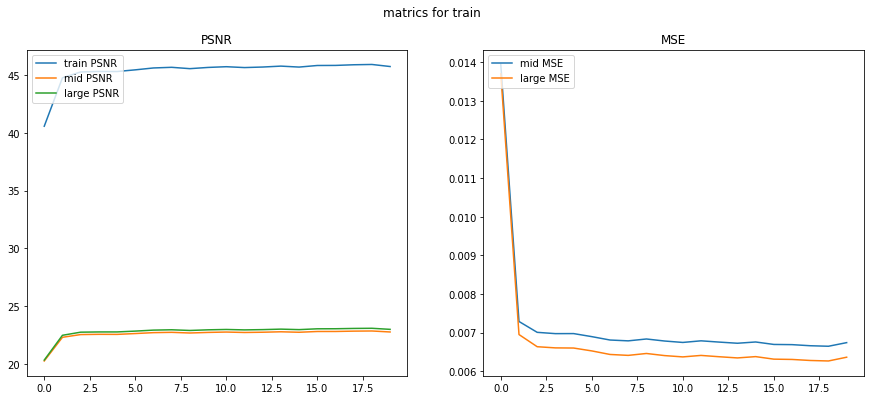

train mean MSE for mid image: 0.007
train mean MSE for large image: 0.007
train mean PSNR for mid image: 22.566
train mean PSNR for large image: 22.780
train mean PSNR: 45.346


In [ ]:
train_model(model, epochs=20)

mean PSNR for mid images: 22.693
mean PSNR for large images: 22.981

mean MSE for mid images: 0.007
mean MSE for large images: 0.006



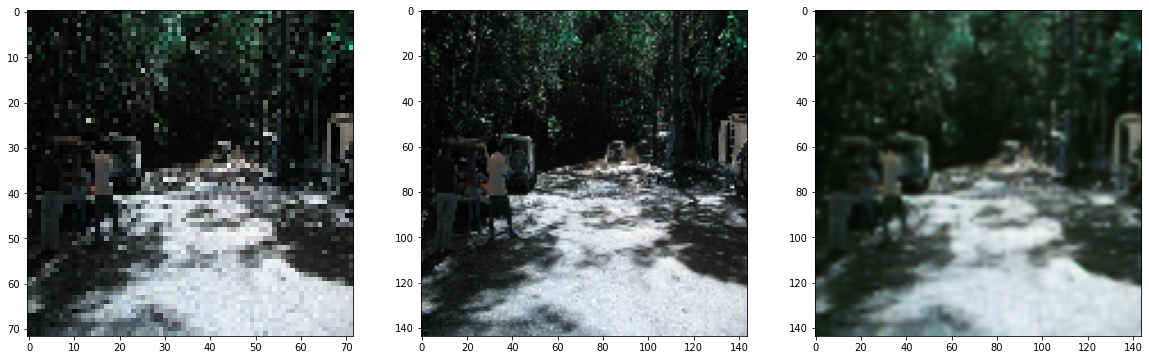

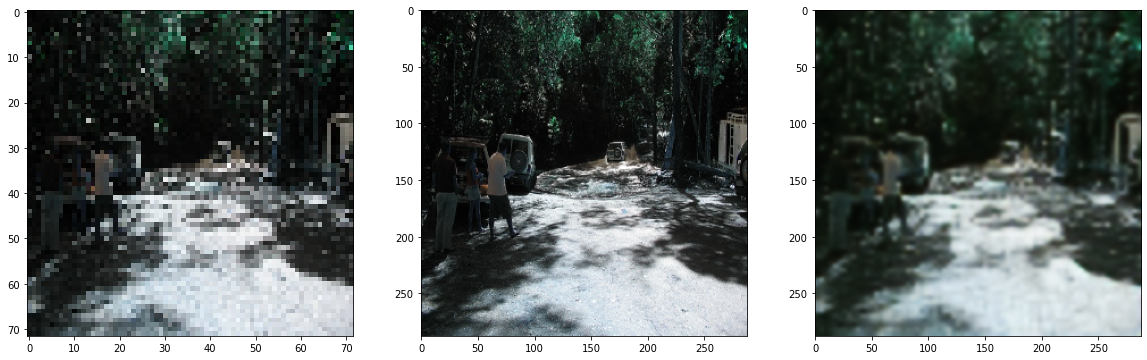

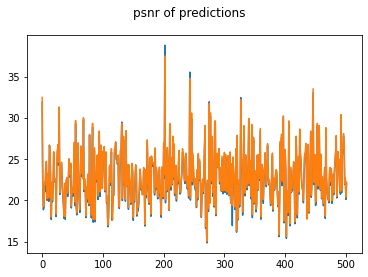

In [ ]:
predict_and_show_results(model, x_test, 1)

Add residual blocks into the process
spend a moment to think, what should be the input and output of the residual-block model

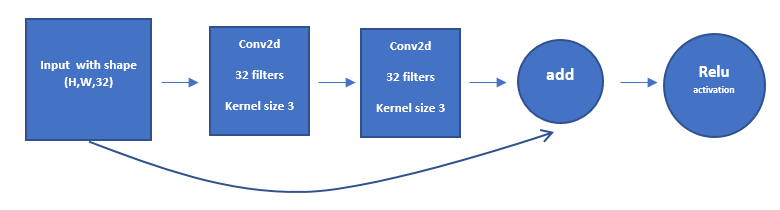

In [ ]:
def get_residual_block(cnl=32):
  input = Input(shape=(None,None,cnl))
  mid = Conv2D(cnl, (3, 3), padding="same", activation=LeakyReLU(alpha=0.2))(input)
  mid = Conv2D(cnl, (3, 3), padding="same", activation=LeakyReLU(alpha=0.2))(mid)
  add_layer = add([input,mid])
  add_layer = LeakyReLU(alpha=0.2)(add_layer)
  return Model(input,add_layer)

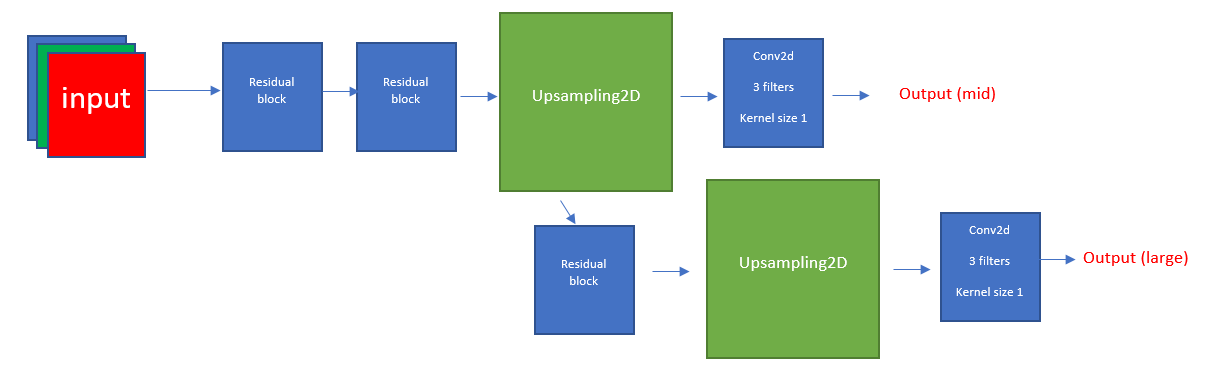

In [ ]:
def create_residual_model():
  input = Input(shape=(None,None,3))
  x = Conv2D(32,1)(input)
  x = Activation(LeakyReLU(alpha=0.2))(x)
  res1 = get_residual_block(32)(x)
  res1 = get_residual_block(32)(res1)
  mid = UpSampling2D(size=2, interpolation='bilinear')(res1)
  large = get_residual_block(32)(mid)
  large = UpSampling2D(size=2, interpolation='bilinear')(large)
  large = Conv2D(3, (1, 1), padding="same", activation="sigmoid",name='out_large')(large)
  mid = Conv2D(3, (1, 1), padding="same", activation="sigmoid", name='out_mid')(mid)
  model = Model(input, [mid,large], name='residual_model')
  model.compile(optimizer=Adam(0.01), loss=psnr_loss, metrics=[psnr, 'mse'])
  return model

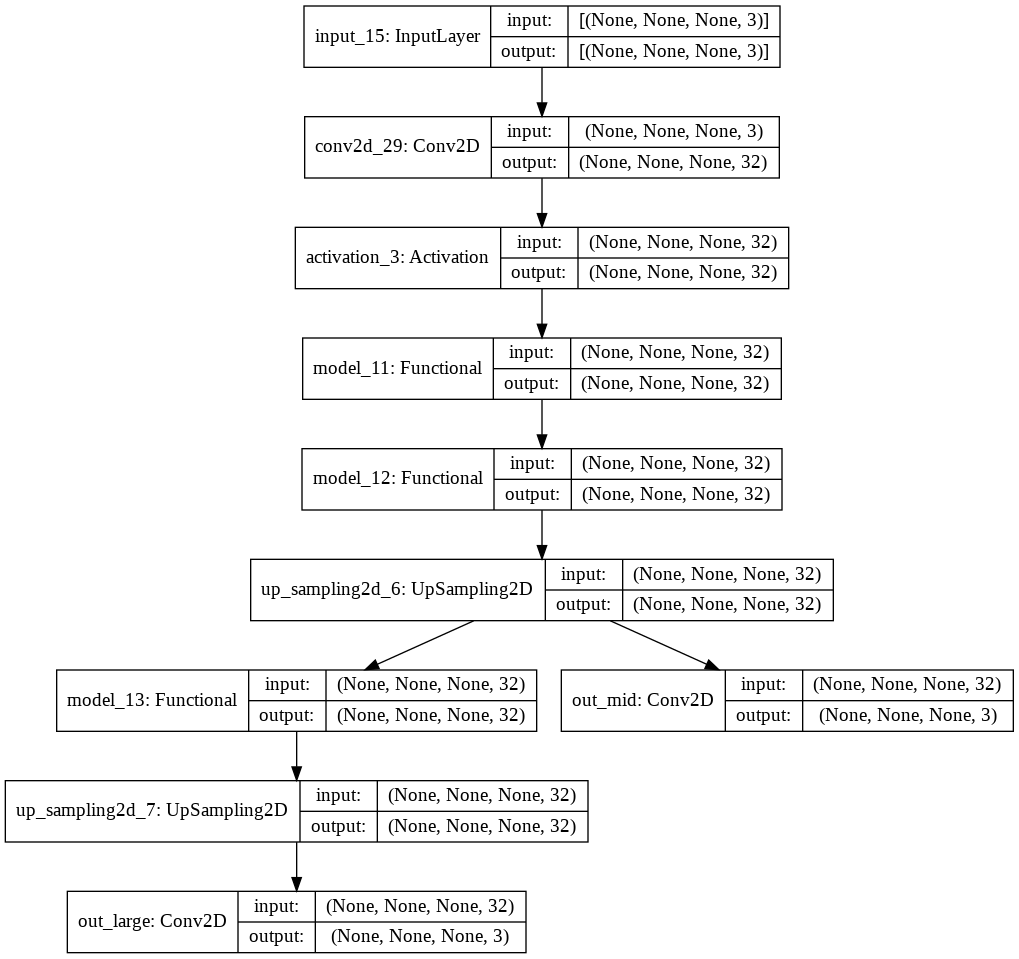

In [ ]:
res_model = create_residual_model()
plot_model(res_model, show_shapes=True, show_layer_names=True)

Epoch 1/20
140/140 [==============================] - 37s 257ms/step - loss: -35.2461 - out_mid_loss: -17.9559 - out_large_loss: -17.2902 - out_mid_psnr: 17.9559 - out_mid_mse: 0.0256 - out_large_psnr: 17.2902 - out_large_mse: 0.0312
Epoch 2/20
140/140 [==============================] - 36s 254ms/step - loss: -44.5786 - out_mid_loss: -22.3033 - out_large_loss: -22.2752 - out_mid_psnr: 22.3033 - out_mid_mse: 0.0073 - out_large_psnr: 22.2752 - out_large_mse: 0.0072
Epoch 3/20
140/140 [==============================] - 36s 255ms/step - loss: -45.0617 - out_mid_loss: -22.5039 - out_large_loss: -22.5578 - out_mid_psnr: 22.5039 - out_mid_mse: 0.0071 - out_large_psnr: 22.5578 - out_large_mse: 0.0068
Epoch 4/20
140/140 [==============================] - 36s 256ms/step - loss: -45.5101 - out_mid_loss: -22.6706 - out_large_loss: -22.8394 - out_mid_psnr: 22.6706 - out_mid_mse: 0.0069 - out_large_psnr: 22.8394 - out_large_mse: 0.0066
Epoch 5/20
140/140 [==============================] - 36s 255ms/

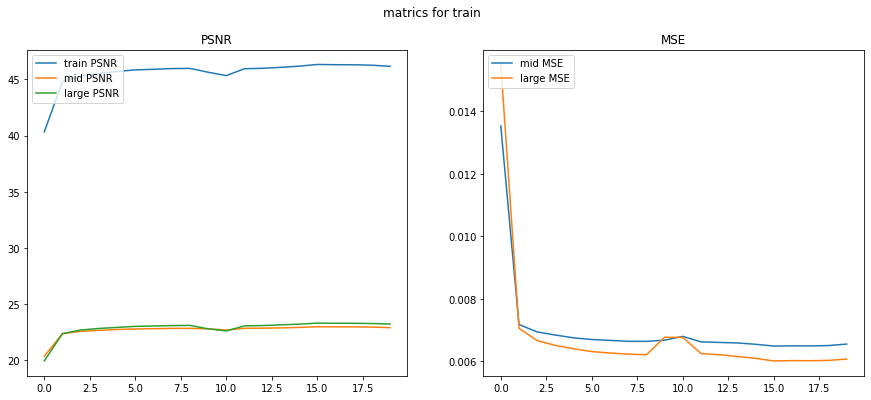

train mean MSE for mid image: 0.007
train mean MSE for large image: 0.007
train mean PSNR for mid image: 22.705
train mean PSNR for large image: 22.884
train mean PSNR: 45.589


In [ ]:
res_model = train_model(res_model, epochs=20)

mean PSNR for mid images: 23.247
mean PSNR for large images: 23.631

mean MSE for mid images: 0.006
mean MSE for large images: 0.006



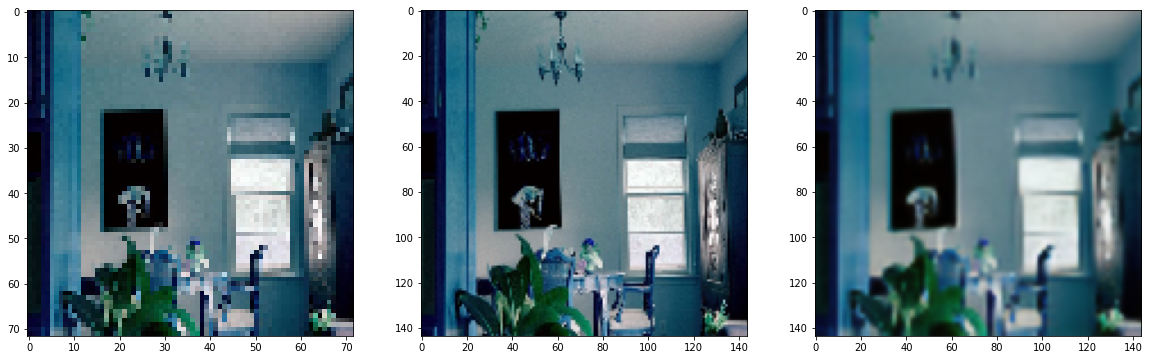

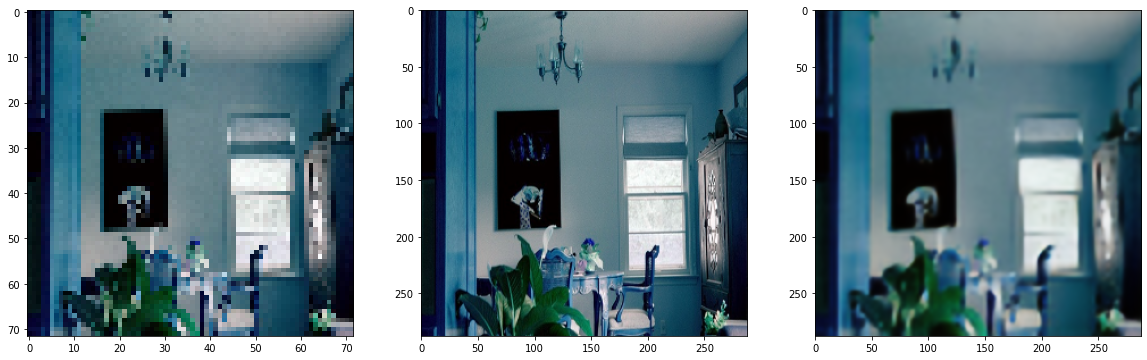

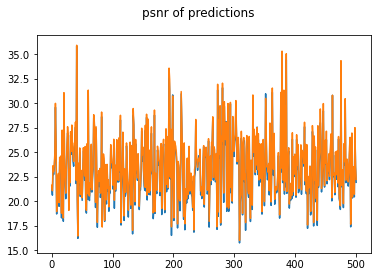

In [ ]:
predict_and_show_results(res_model, x_test, 10)


replace the residual blocks we defined above with a dilated (Atrous) convolutional block as described below:
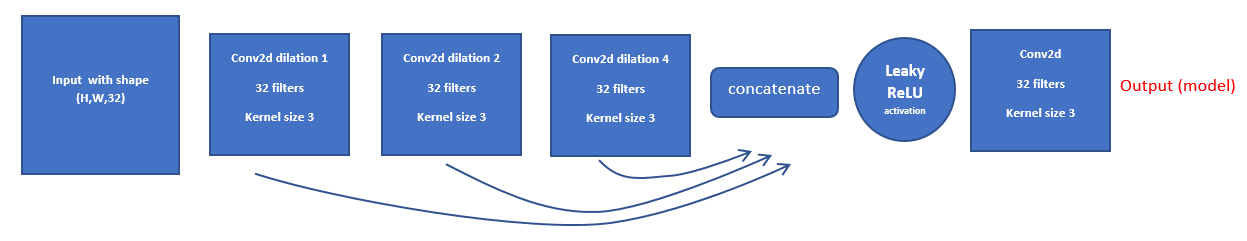


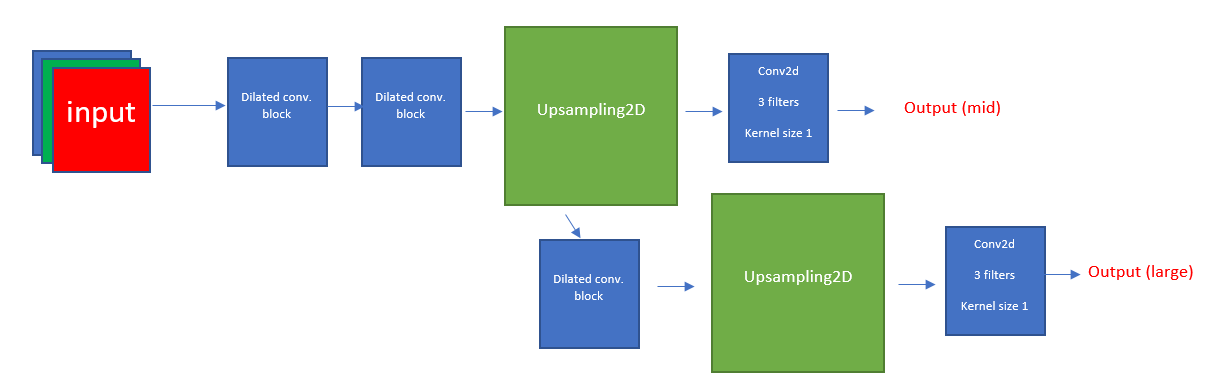

In [ ]:
def get_dilated_conv_block(cnl=32, kernal=3):
  input = Input(shape=(None,None,cnl))
  dilated1 = Conv2D(cnl, (kernal, kernal), padding="same", activation='sigmoid', dilation_rate=1)(input)
  dilated2 = Conv2D(cnl, (kernal, kernal), padding="same", activation='sigmoid',dilation_rate=2)(input)
  dilated4 = Conv2D(cnl, (kernal, kernal), padding="same", activation='sigmoid',dilation_rate=4)(input)
  concatinate = concatenate([dilated1,dilated2,dilated4], axis=-1)
  concatinate = LeakyReLU(alpha=0.2)(concatinate)
  concatinate = Conv2D(cnl, (1,1), padding="same", activation=LeakyReLU(alpha=0.2))(concatinate)
  return Model(input,concatinate)


In [ ]:
def create_dilated_conv_model():
  input = Input(shape=(None,None,3))
  x = Conv2D(32,1)(input)
  x = Activation(LeakyReLU(alpha=0.2))(x)
  x = get_residual_block(32)(x)
  res1 = get_dilated_conv_block(32)(x)
  res2 = get_dilated_conv_block(32)(res1)
  mid = UpSampling2D(size=2, interpolation='bilinear')(res2)
  large = get_dilated_conv_block(32)(mid)
  mid = Conv2D(3, (1, 1), padding="same", activation="sigmoid", name='out_mid')(mid)
  large = get_residual_block(32)(large)
  large = get_dilated_conv_block(32)(large)
  large = UpSampling2D(size=2, interpolation='bilinear')(large)
  large = Conv2D(3, (1, 1), activation="sigmoid",name='out_large')(large)
  model = Model(input, [mid,large], name='dilated_conv_model')
  model.compile(optimizer=Adam(0.01), loss=psnr_loss, metrics=[psnr, 'mse'])
  return model

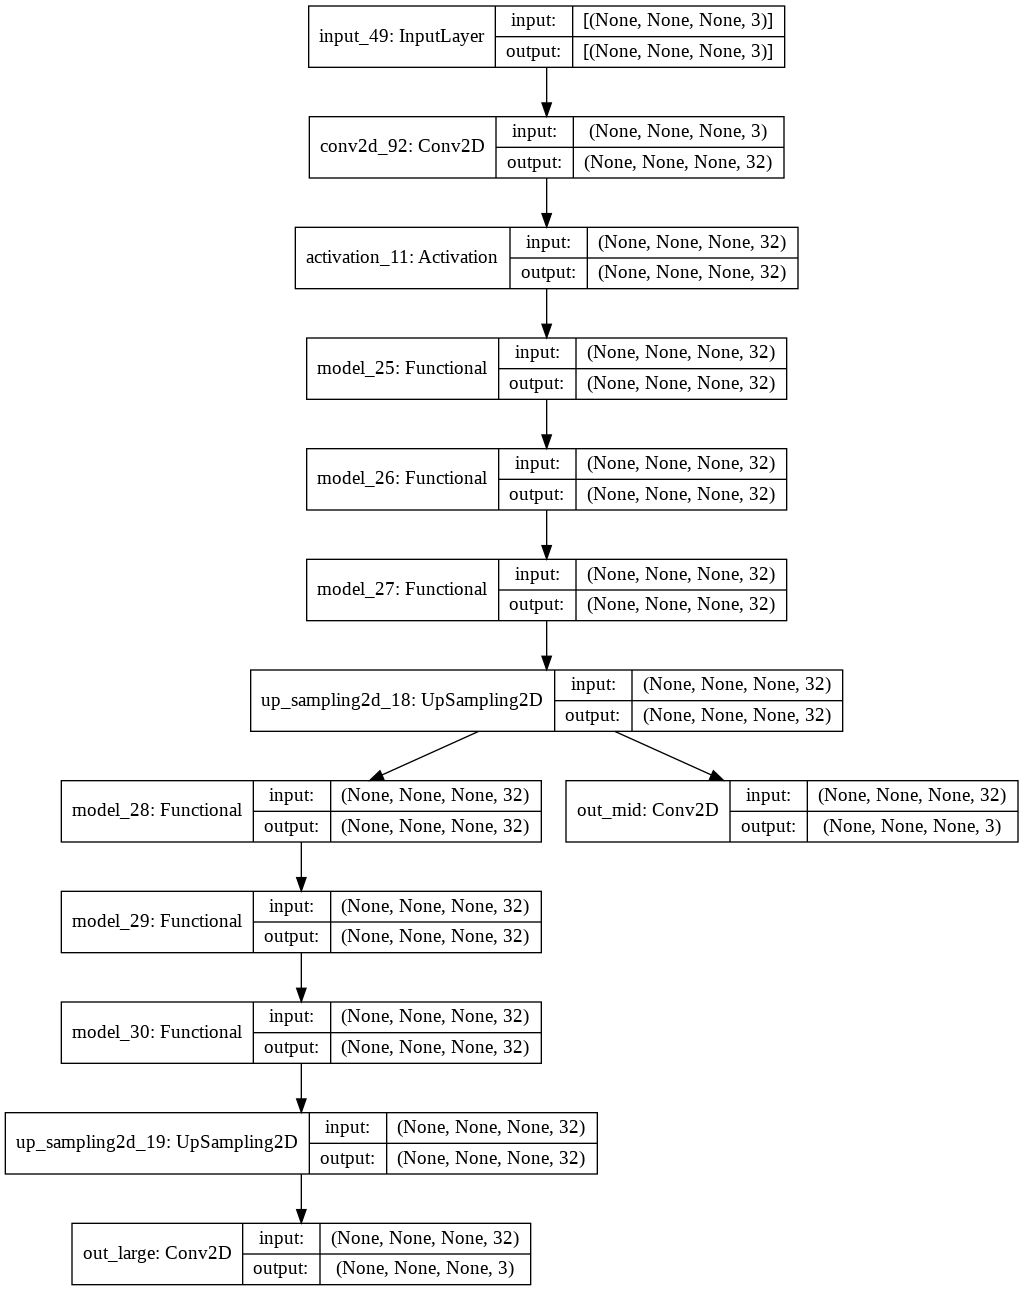

In [ ]:
dilated_conv_model = create_dilated_conv_model()
plot_model(dilated_conv_model, show_shapes=True, show_layer_names=True)

Epoch 1/30
140/140 [==============================] - 53s 355ms/step - loss: -30.7719 - out_mid_loss: -16.0458 - out_large_loss: -14.7261 - out_mid_psnr: 16.0458 - out_mid_mse: 0.0374 - out_large_psnr: 14.7261 - out_large_mse: 0.0500
Epoch 2/30
140/140 [==============================] - 50s 356ms/step - loss: -40.2697 - out_mid_loss: -21.1977 - out_large_loss: -19.0719 - out_mid_psnr: 21.1977 - out_mid_mse: 0.0090 - out_large_psnr: 19.0719 - out_large_mse: 0.0145
Epoch 3/30
140/140 [==============================] - 50s 358ms/step - loss: -41.5915 - out_mid_loss: -21.8416 - out_large_loss: -19.7499 - out_mid_psnr: 21.8416 - out_mid_mse: 0.0080 - out_large_psnr: 19.7499 - out_large_mse: 0.0127
Epoch 4/30
140/140 [==============================] - 51s 361ms/step - loss: -42.1251 - out_mid_loss: -21.7096 - out_large_loss: -20.4155 - out_mid_psnr: 21.7096 - out_mid_mse: 0.0081 - out_large_psnr: 20.4155 - out_large_mse: 0.0105
Epoch 5/30
140/140 [==============================] - 51s 362ms/

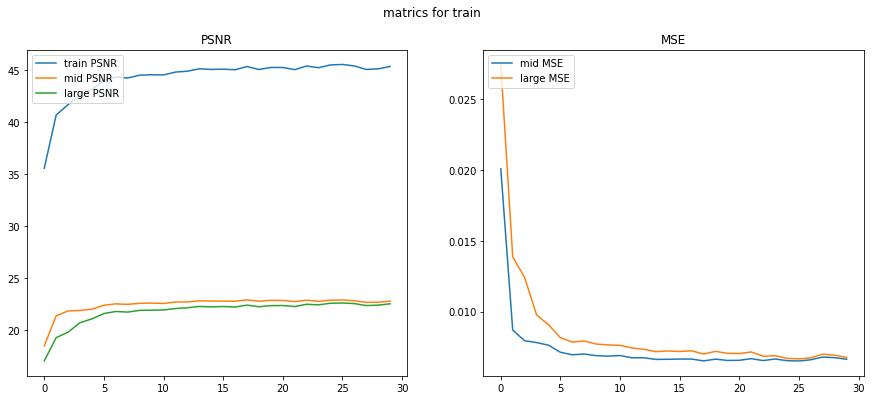

train mean MSE for mid image: 0.007
train mean MSE for large image: 0.008
train mean PSNR for mid image: 22.463
train mean PSNR for large image: 21.789
train mean PSNR: 44.252


In [ ]:

dilated_conv_model = train_model(dilated_conv_model,epochs=30, idx=4)

mean PSNR for mid images: 23.147
mean PSNR for large images: 23.013

mean MSE for mid images: 0.006
mean MSE for large images: 0.006



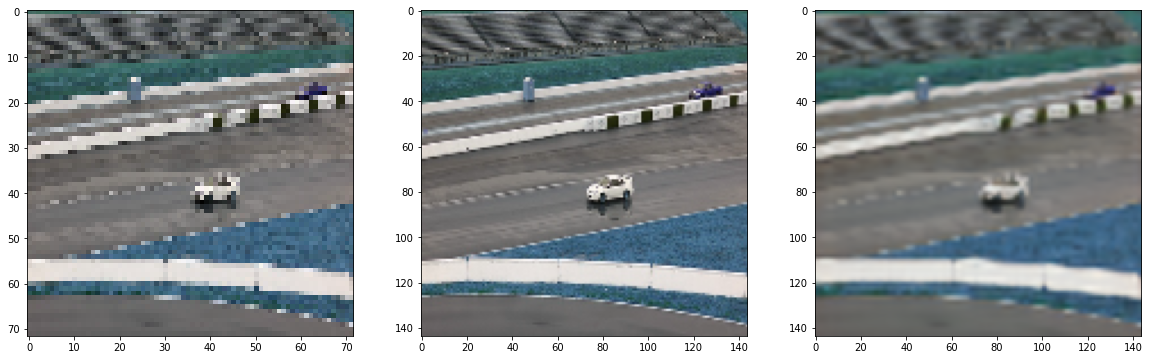

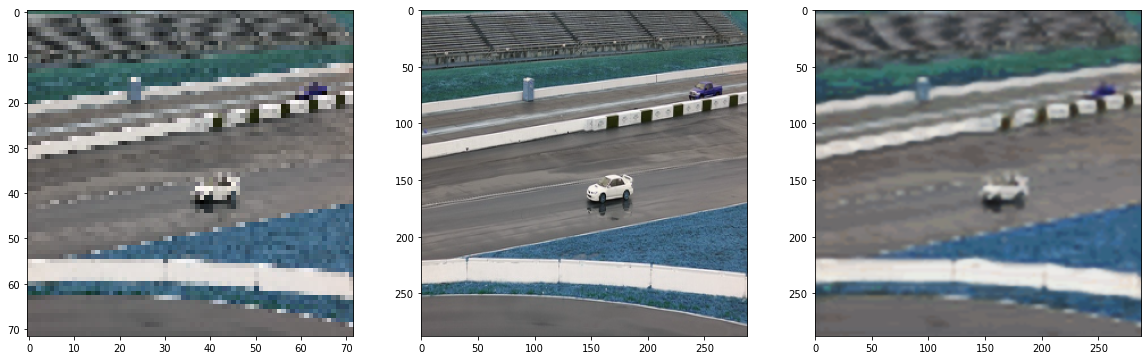

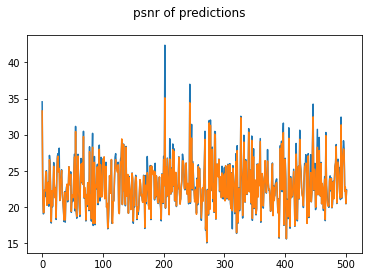

In [ ]:
predict_and_show_results(dilated_conv_model, x_test, 5)


Add pretrained network (either efficientnet / resnet or any other) feature extractor to the network (note that the input to the network is only being read once)
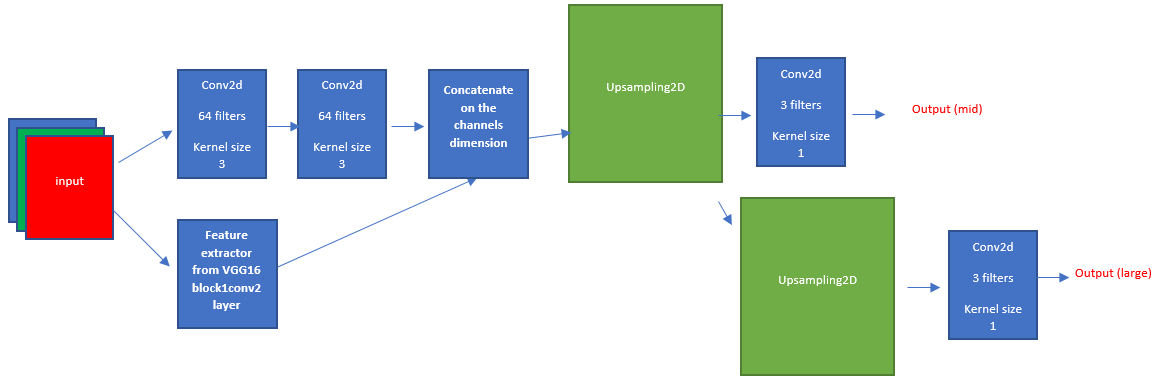

In [ ]:
def get_vgg16_feature_extractor():
  vgg16_model = VGG16(weights='imagenet',include_top=False)
  featur_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block1_conv2').output)
  for l in featur_extractor.layers:
    l.trainable=False
  return featur_extractor


In [ ]:
def create_transfer_learning_model():
  input = Input(shape=(None,None,3))
  fe = get_vgg16_feature_extractor()(input)
  x = Conv2D(64,1)(input)
  x = Conv2D(64,1)(x)
  x = Conv2D(64,1)(x)
  conc = concatenate([x,fe], axis=-1)
  mid = UpSampling2D(size=2, interpolation='bilinear')(conc)
  large = UpSampling2D(size=2, interpolation='bilinear')(mid)
  mid = Conv2D(3, (1, 1), padding="same", activation="sigmoid", name='out_mid')(mid)
  large = Conv2D(3, (1, 1), activation="sigmoid",name='out_large')(large)
  model = Model(input, [mid,large], name='transfer_learning_model_vgg16')
  model.compile(optimizer=Adam(0.01), loss=psnr_loss, metrics=[psnr, 'mse'])
  return model

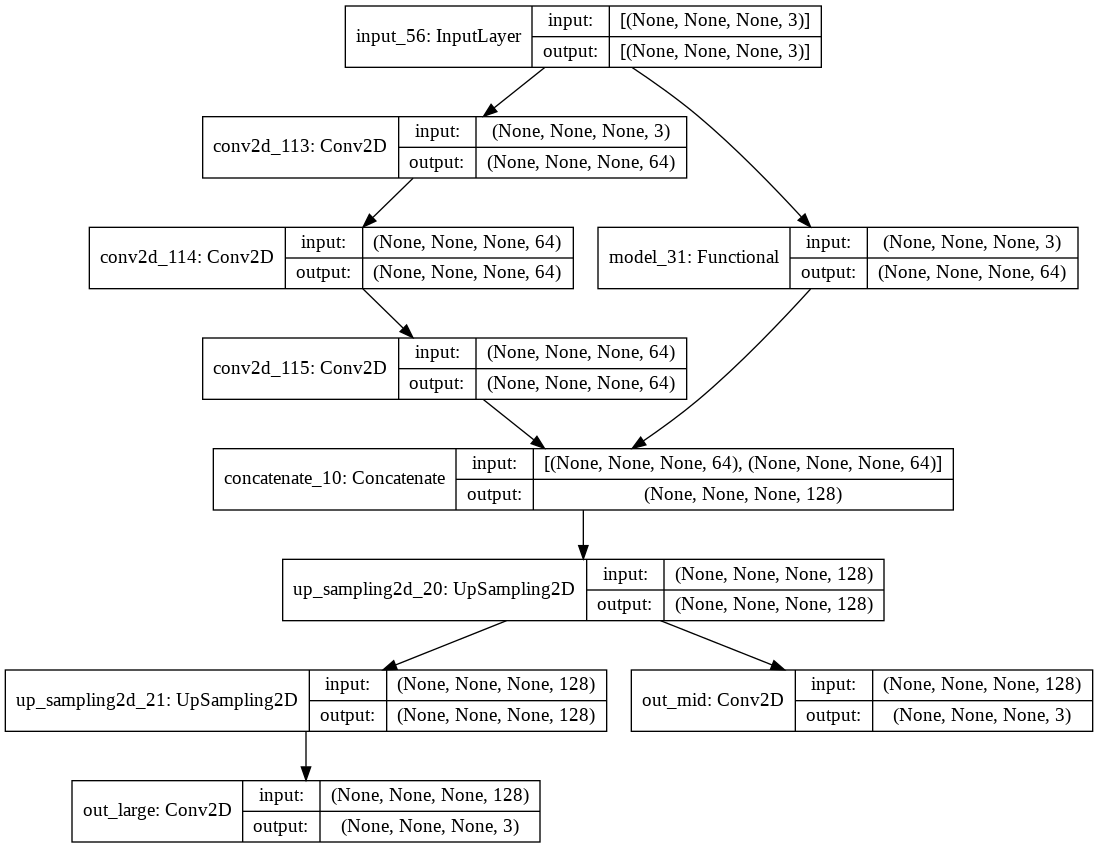

In [ ]:
transfer_learning = create_transfer_learning_model()
plot_model(transfer_learning, show_shapes=True, show_layer_names=True)

Epoch 1/30
140/140 [==============================] - 41s 282ms/step - loss: -35.8794 - out_mid_loss: -17.7898 - out_large_loss: -18.0897 - out_mid_psnr: 17.7898 - out_mid_mse: 0.0277 - out_large_psnr: 18.0897 - out_large_mse: 0.0325
Epoch 2/30
140/140 [==============================] - 39s 278ms/step - loss: -43.3490 - out_mid_loss: -21.5963 - out_large_loss: -21.7528 - out_mid_psnr: 21.5963 - out_mid_mse: 0.0082 - out_large_psnr: 21.7528 - out_large_mse: 0.0078
Epoch 3/30
140/140 [==============================] - 39s 278ms/step - loss: -43.7088 - out_mid_loss: -21.7526 - out_large_loss: -21.9563 - out_mid_psnr: 21.7526 - out_mid_mse: 0.0080 - out_large_psnr: 21.9563 - out_large_mse: 0.0076
Epoch 4/30
140/140 [==============================] - 39s 279ms/step - loss: -43.9206 - out_mid_loss: -21.8313 - out_large_loss: -22.0893 - out_mid_psnr: 21.8313 - out_mid_mse: 0.0078 - out_large_psnr: 22.0893 - out_large_mse: 0.0074
Epoch 5/30
140/140 [==============================] - 39s 278ms/

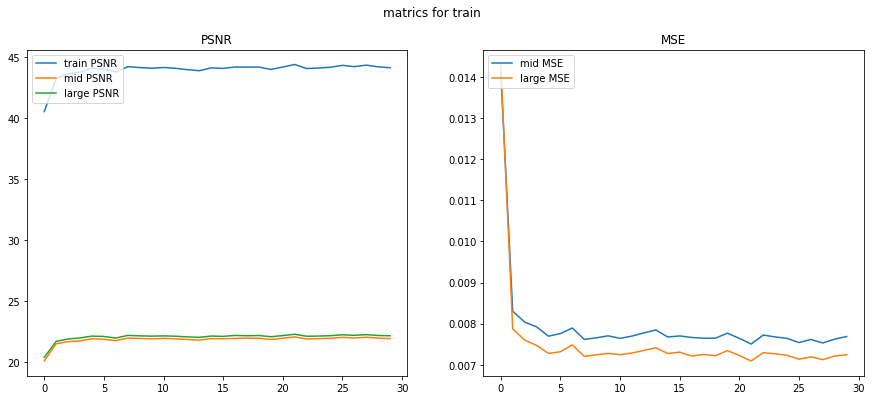

train mean MSE for mid image: 0.008
train mean MSE for large image: 0.008
train mean PSNR for mid image: 21.865
train mean PSNR for large image: 22.085
train mean PSNR: 43.950


In [ ]:

transfer_learning = train_model(transfer_learning, epochs=30)

mean PSNR for mid images: 22.318
mean PSNR for large images: 22.549

mean MSE for mid images: 0.007
mean MSE for large images: 0.007



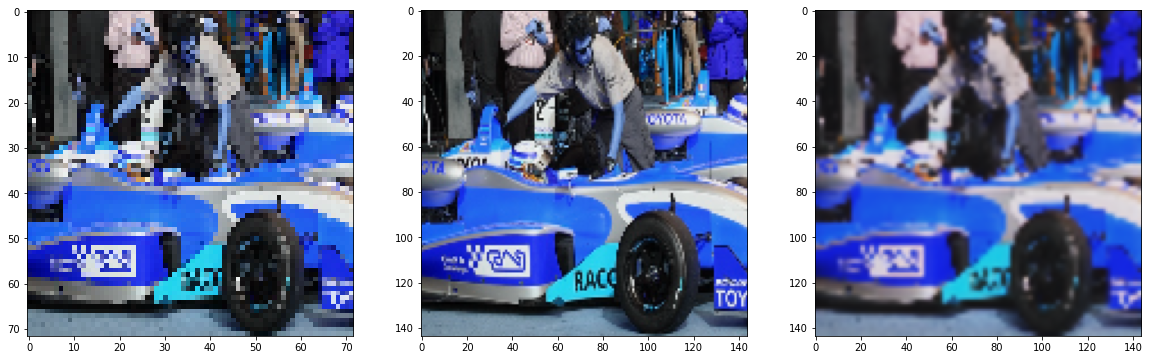

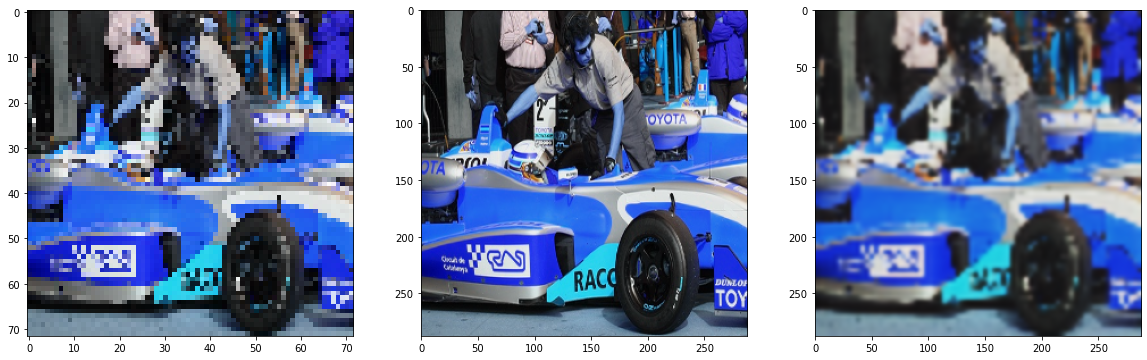

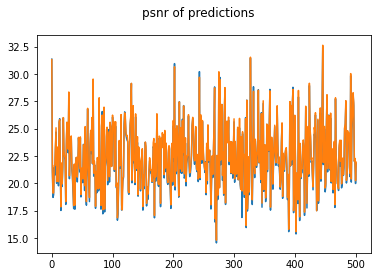

In [ ]:
predict_and_show_results(transfer_learning, x_test, 3)


replace the Upsampling2D layer with tf.nn.depth_to_space with parameters (x,scale)
* Note that the number of filters in the preceding layer (num of input channels to the tf.nn.depth_to_space) should be divisible by (scale^2)

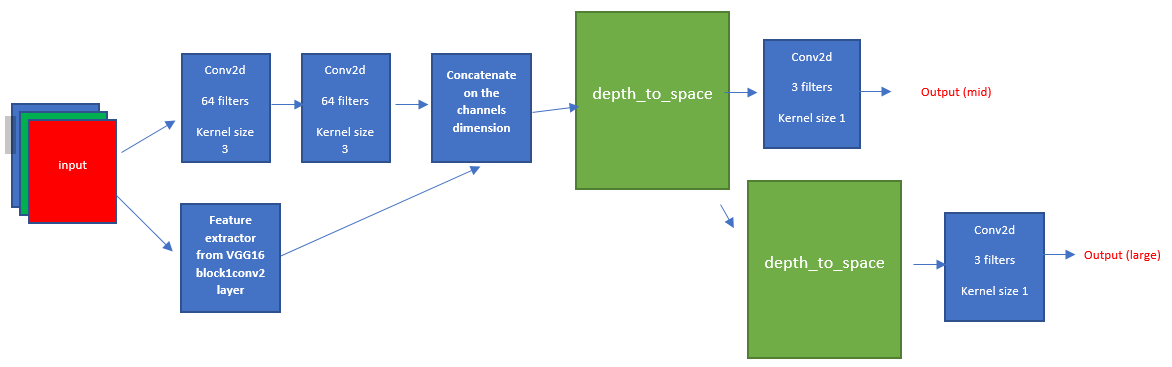

In [ ]:
def create_transfer_learning_model_with_dts():
  input = Input(shape=(None,None,3))
  fe = get_vgg16_feature_extractor()(input)
  x = Conv2D(32,1)(input)
  x = Activation(LeakyReLU(alpha=0.2))(x)
  x = get_residual_block(32)(x)
  x = get_residual_block(32)(x)
  conc = concatenate([x,fe], axis=-1)
  conc = tf.nn.depth_to_space(conc, 2)
  mid = Conv2D(3, (1, 1), padding="same", activation="sigmoid")(conc)
  mid = Activation('sigmoid', name='out_mid')(mid)
  large = Conv2D(32,1)(conc)
  large = tf.nn.depth_to_space(large, 2)
  large = Conv2D(3, (1, 1), activation="sigmoid")(large)
  large = Activation('sigmoid',name='out_large')(large)
  model = Model(input, [mid,large], name='transfer_learning_model_with_dts')
  model.compile(optimizer='adam', loss=psnr_loss, metrics=[psnr, 'mse'])
  return model



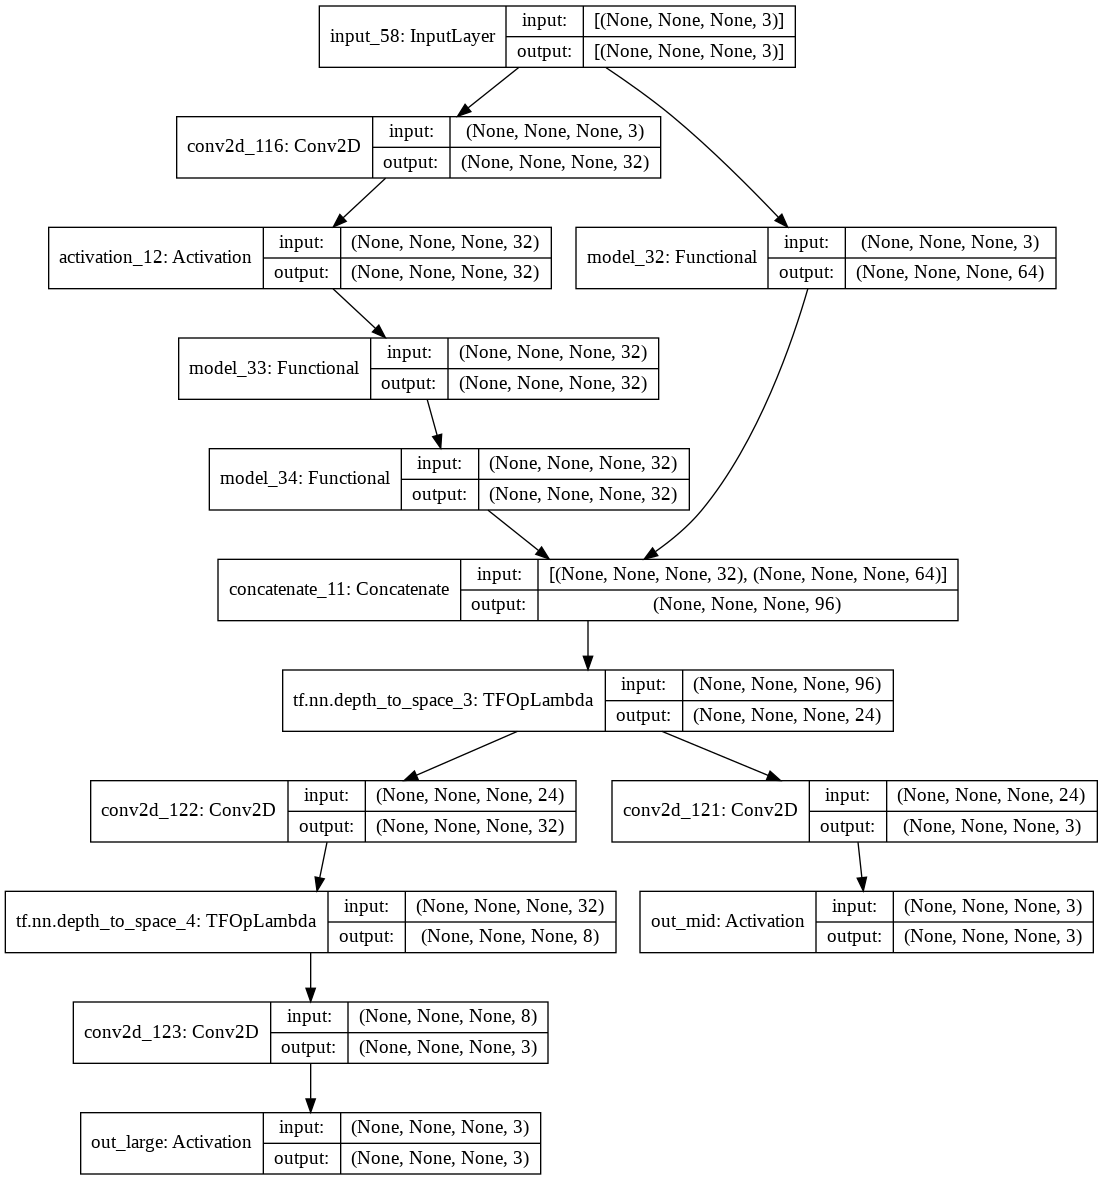

In [ ]:
dts_model = create_transfer_learning_model_with_dts()
plot_model(dts_model, show_shapes=True, show_layer_names=True)

Epoch 1/20
140/140 [==============================] - 36s 243ms/step - loss: -21.0016 - out_mid_loss: -10.4997 - out_large_loss: -10.5019 - out_mid_psnr: 10.4997 - out_mid_mse: 0.0992 - out_large_psnr: 10.5019 - out_large_mse: 0.0990
Epoch 2/20
140/140 [==============================] - 34s 243ms/step - loss: -22.6843 - out_mid_loss: -11.3403 - out_large_loss: -11.3440 - out_mid_psnr: 11.3403 - out_mid_mse: 0.0809 - out_large_psnr: 11.3440 - out_large_mse: 0.0808
Epoch 3/20
140/140 [==============================] - 34s 245ms/step - loss: -22.7381 - out_mid_loss: -11.3812 - out_large_loss: -11.3569 - out_mid_psnr: 11.3812 - out_mid_mse: 0.0802 - out_large_psnr: 11.3569 - out_large_mse: 0.0806
Epoch 4/20
140/140 [==============================] - 34s 243ms/step - loss: -22.7595 - out_mid_loss: -11.3937 - out_large_loss: -11.3658 - out_mid_psnr: 11.3937 - out_mid_mse: 0.0799 - out_large_psnr: 11.3658 - out_large_mse: 0.0804
Epoch 5/20
140/140 [==============================] - 34s 242ms/

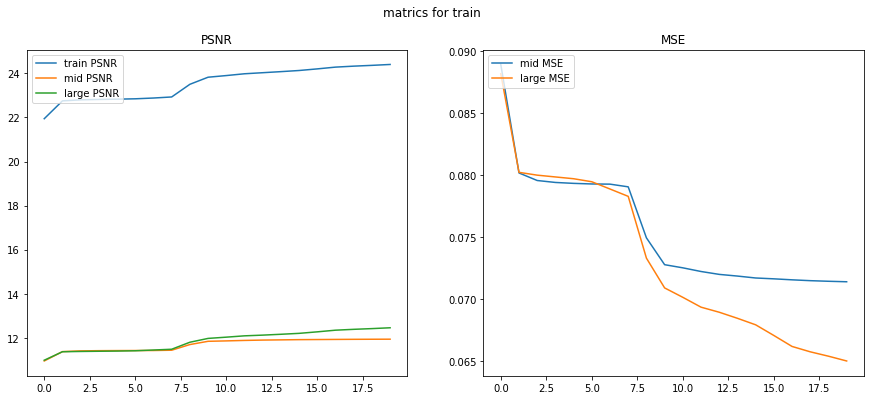

train mean MSE for mid image: 0.076
train mean MSE for large image: 0.073
train mean PSNR for mid image: 11.679
train mean PSNR for large image: 11.860
train mean PSNR: 23.539


In [ ]:

dts_model = train_model(dts_model, epochs=20)

mean PSNR for mid images: 11.781
mean PSNR for large images: 12.290

mean MSE for mid images: 0.074
mean MSE for large images: 0.067



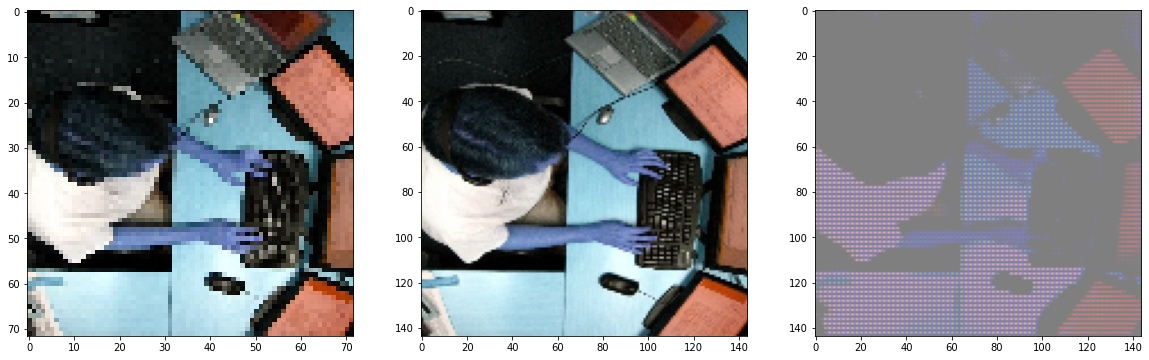

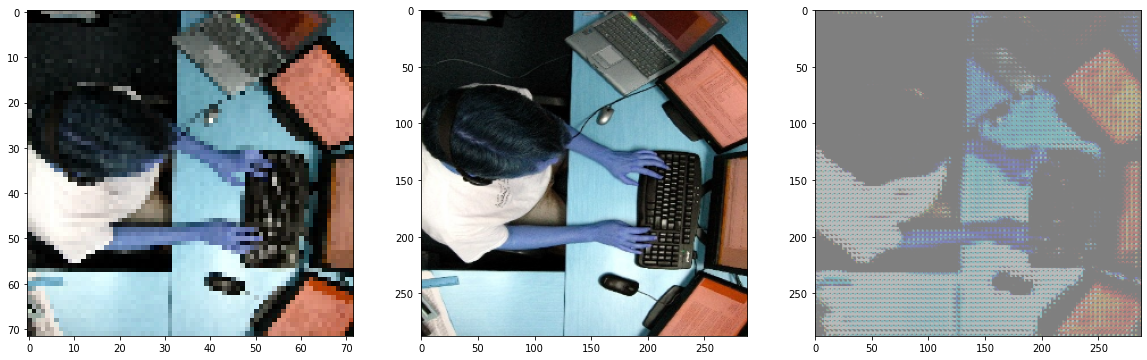

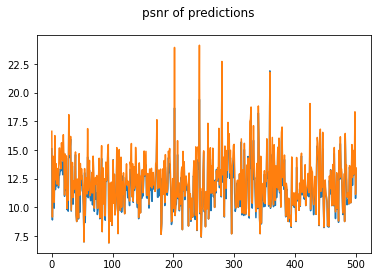

In [ ]:
predict_and_show_results(dts_model, x_test, 4)


Take one or more of the networks that you have trained during the exercise (or another network you can think of) and train it to get the best result you can both for the optimization metric and in terms of visual results

In [ ]:
def create_deeper_reedual_model():
  input = Input(shape=(None,None,3))
  x = Conv2D(32,1)(input)
  x = Activation(LeakyReLU(alpha=0.2))(x)
  res1 = get_residual_block(32)(x)
  res1 = ReLU()(res1)
  res1 = get_residual_block(32)(res1)
  res1 = Conv2D(32,1)(res1)
  res1 = ReLU()(res1)
  res1 = get_residual_block(32)(res1)
  res1 = ReLU()(res1)
  res1 = get_residual_block(32)(res1)
  res1 = Conv2D(32,1)(res1)
  res1 = ReLU()(res1)
  # mid = tf.nn.depth_to_space(res1,2)
  mid = UpSampling2D(size=2, interpolation='bilinear')(res1)
  large = UpSampling2D(size=2, interpolation='bilinear')(mid)
  large = Conv2D(3, (1, 1), padding="same", activation="sigmoid",name='out_large')(large)
  mid = Conv2D(3, (1, 1), padding="same", activation="sigmoid", name='out_mid')(mid)
  model = Model(input, [mid,large], name='deeper_reedual_model')
  model.compile(optimizer=Adam(0.01), loss=psnr_loss, metrics=[psnr, 'mse'])
  return model

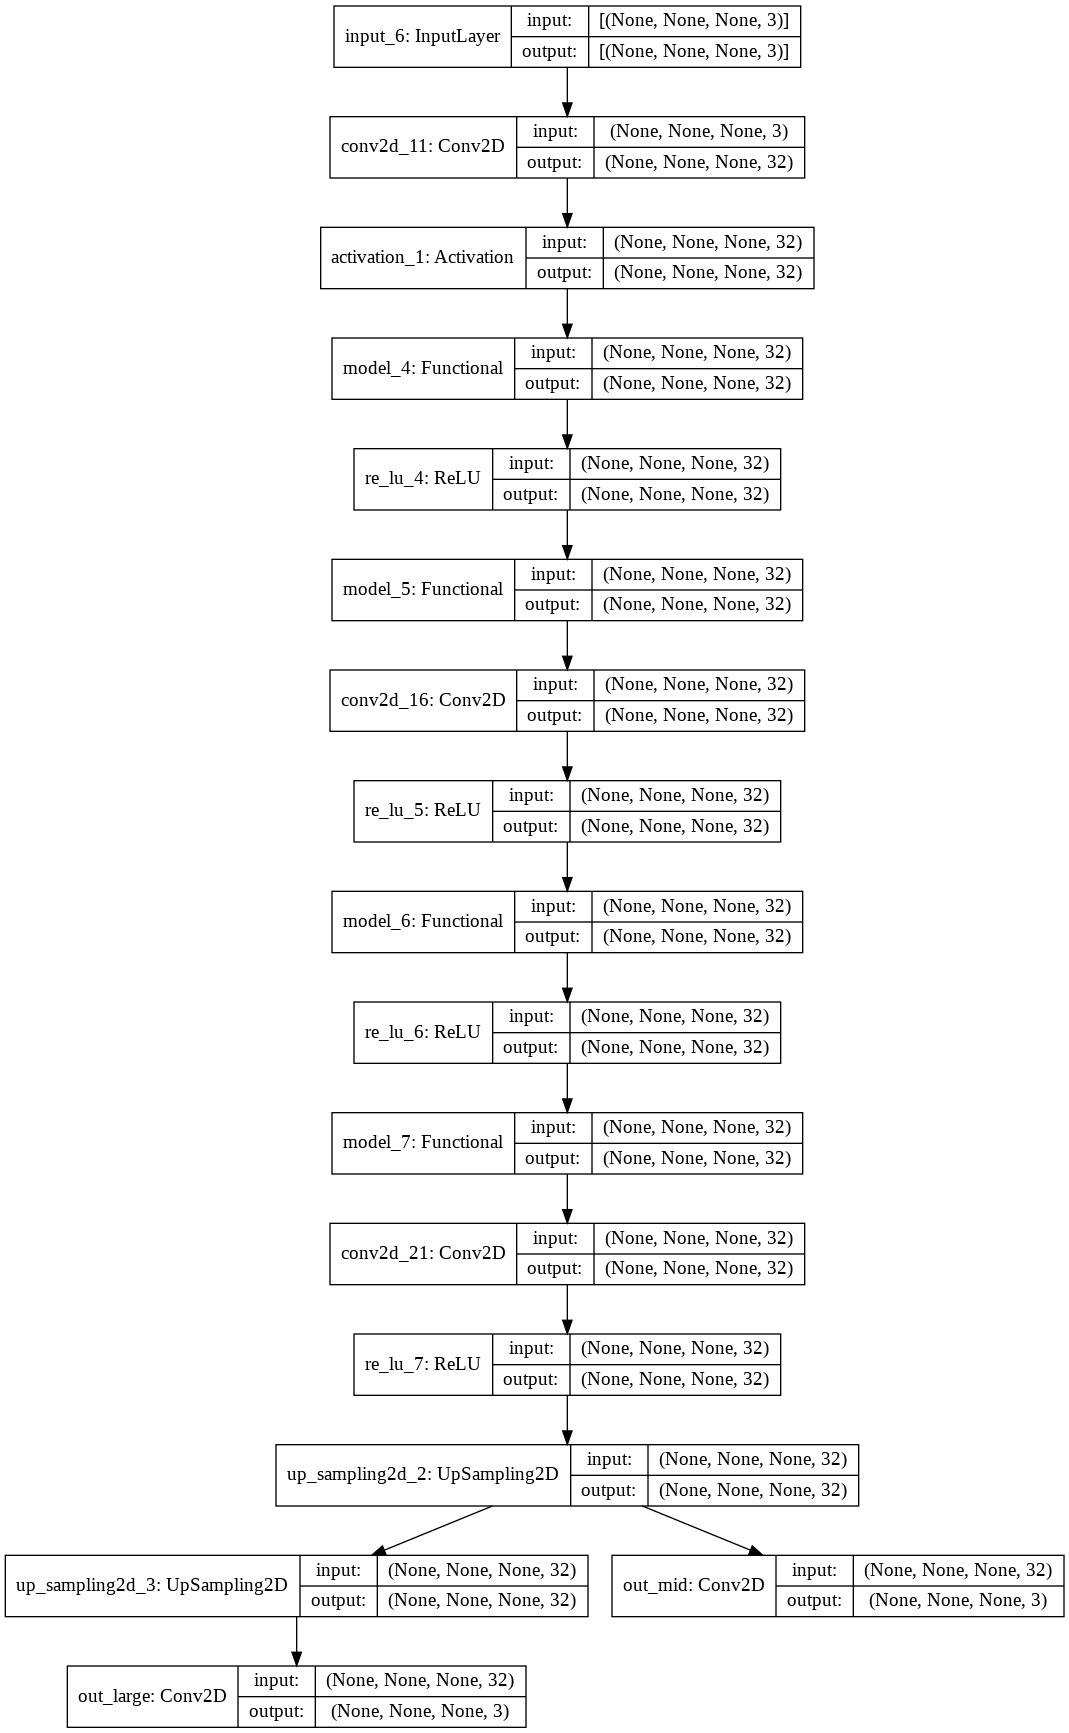

In [ ]:
deeper_resedual = create_deeper_reedual_model()
plot_model(deeper_resedual, show_shapes=True, show_layer_names=True)

Epoch 1/10
140/140 [==============================] - 35s 243ms/step - loss: -30.9402 - out_mid_loss: -15.4597 - out_large_loss: -15.4805 - out_mid_psnr: 15.4597 - out_mid_mse: 0.0443 - out_large_psnr: 15.4805 - out_large_mse: 0.0430
Epoch 2/10
140/140 [==============================] - 34s 246ms/step - loss: -39.1071 - out_mid_loss: -19.5141 - out_large_loss: -19.5930 - out_mid_psnr: 19.5141 - out_mid_mse: 0.0133 - out_large_psnr: 19.5930 - out_large_mse: 0.0131
Epoch 3/10
140/140 [==============================] - 35s 247ms/step - loss: -41.8942 - out_mid_loss: -20.8813 - out_large_loss: -21.0128 - out_mid_psnr: 20.8813 - out_mid_mse: 0.0096 - out_large_psnr: 21.0128 - out_large_mse: 0.0093
Epoch 4/10
140/140 [==============================] - 35s 245ms/step - loss: -43.2879 - out_mid_loss: -21.5575 - out_large_loss: -21.7304 - out_mid_psnr: 21.5575 - out_mid_mse: 0.0084 - out_large_psnr: 21.7304 - out_large_mse: 0.0080
Epoch 5/10
140/140 [==============================] - 35s 246ms/

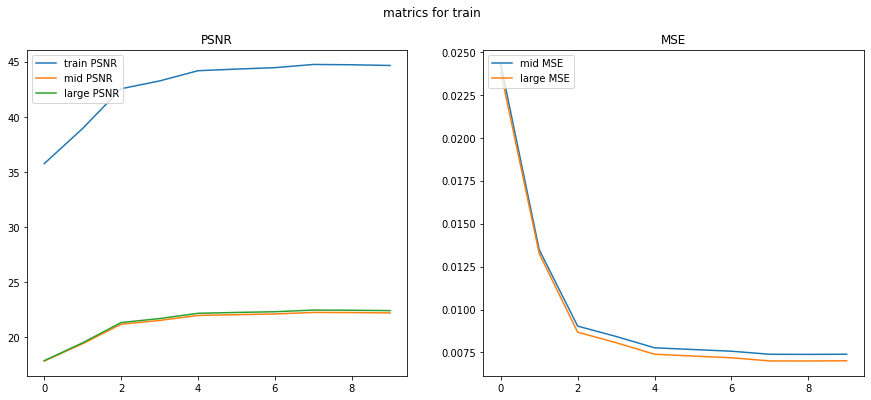

train mean MSE for mid image: 0.010
train mean MSE for large image: 0.010
train mean PSNR for mid image: 21.297
train mean PSNR for large image: 21.463
train mean PSNR: 42.761


In [ ]:
deeper_resedual = train_model(deeper_resedual, epochs=10)

mean PSNR for mid images: 22.521
mean PSNR for large images: 22.718

mean MSE for mid images: 0.007
mean MSE for large images: 0.007



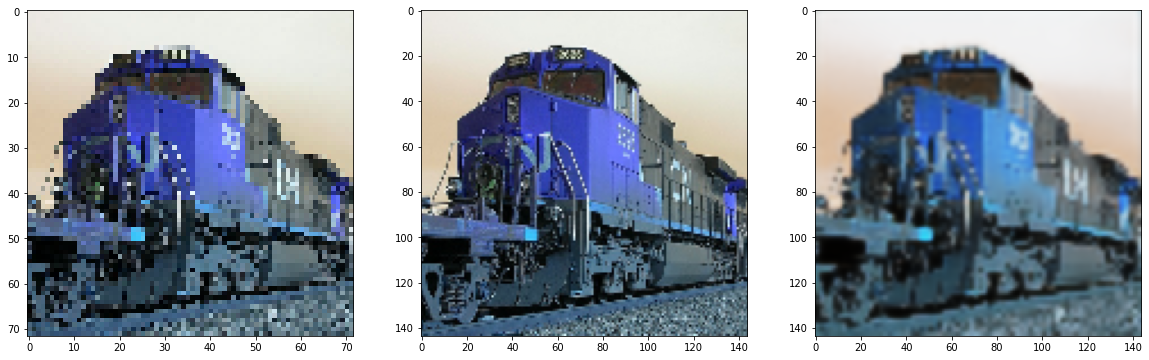

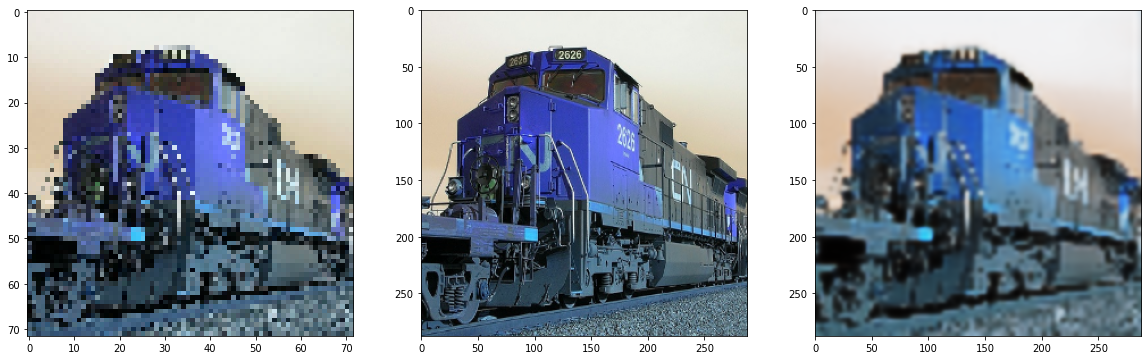

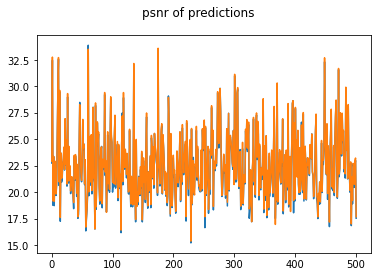

In [ ]:
predict_and_show_results(deeper_resedual, x_test, 4)

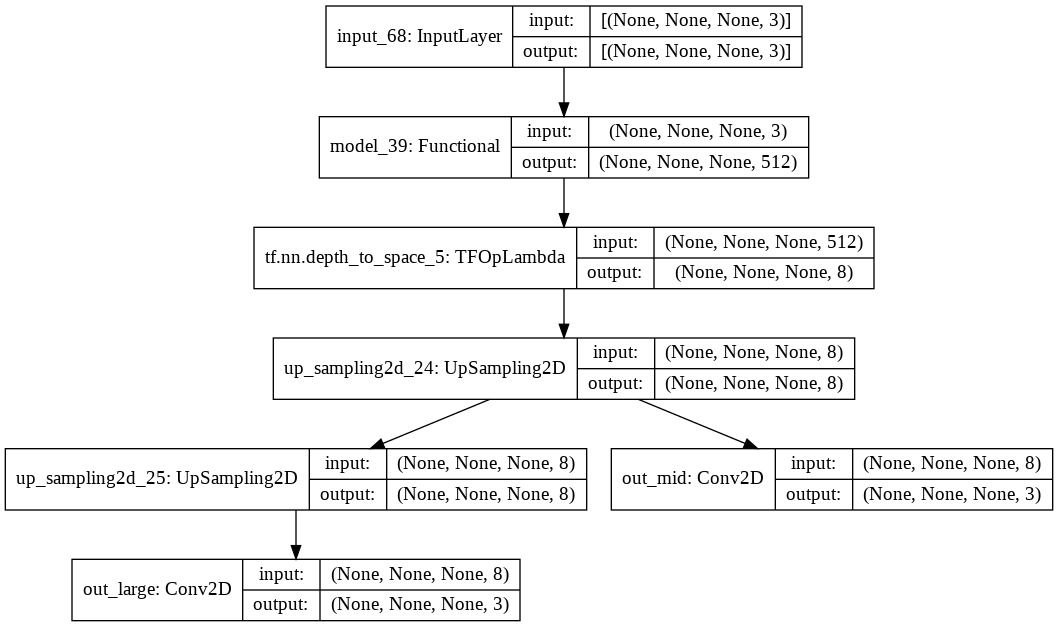

In [ ]:
def resnet_feature_extractor():
  resnet = ResNet50(include_top=False, weights='imagenet')
  featur_extractor = Model(inputs=resnet.input, outputs=resnet.get_layer('conv3_block4_out').output)
  for l in featur_extractor.layers:
    l.trainale = False
  inp = Input(shape=(None,None, 3))
  fe = featur_extractor(inp)
  mid = tf.nn.depth_to_space(fe, 8)
  mid = UpSampling2D(size=2, interpolation='bilinear')(mid)
  large = UpSampling2D(size=2, interpolation='bilinear')(mid)
  large = Conv2D(3, (1, 1), padding="same", activation="sigmoid",name='out_large')(large)
  mid = Conv2D(3, (1, 1), padding="same", activation="sigmoid", name='out_mid')(mid)
  model = Model(inp, [mid,large], name='resnet_feature_extractor_model')
  model.compile(optimizer=Adam(0.01),loss=psnr_loss, metrics=[psnr, 'mse'])
  return model

resnet_fe = resnet_feature_extractor()
plot_model(resnet_fe, show_shapes=True, show_layer_names=True)

Epoch 1/20
140/140 [==============================] - 37s 242ms/step - loss: -31.3299 - out_mid_loss: -15.0010 - out_large_loss: -16.3290 - out_mid_psnr: 15.0010 - out_mid_mse: 0.0499 - out_large_psnr: 16.3290 - out_large_mse: 0.0325
Epoch 2/20
140/140 [==============================] - 34s 241ms/step - loss: -39.3590 - out_mid_loss: -19.6411 - out_large_loss: -19.7179 - out_mid_psnr: 19.6411 - out_mid_mse: 0.0124 - out_large_psnr: 19.7179 - out_large_mse: 0.0122
Epoch 3/20
140/140 [==============================] - 34s 243ms/step - loss: -40.4588 - out_mid_loss: -20.1948 - out_large_loss: -20.2639 - out_mid_psnr: 20.1948 - out_mid_mse: 0.0111 - out_large_psnr: 20.2639 - out_large_mse: 0.0109
Epoch 4/20
140/140 [==============================] - 34s 244ms/step - loss: -41.0442 - out_mid_loss: -20.4879 - out_large_loss: -20.5563 - out_mid_psnr: 20.4879 - out_mid_mse: 0.0104 - out_large_psnr: 20.5563 - out_large_mse: 0.0103
Epoch 5/20
140/140 [==============================] - 35s 246ms/

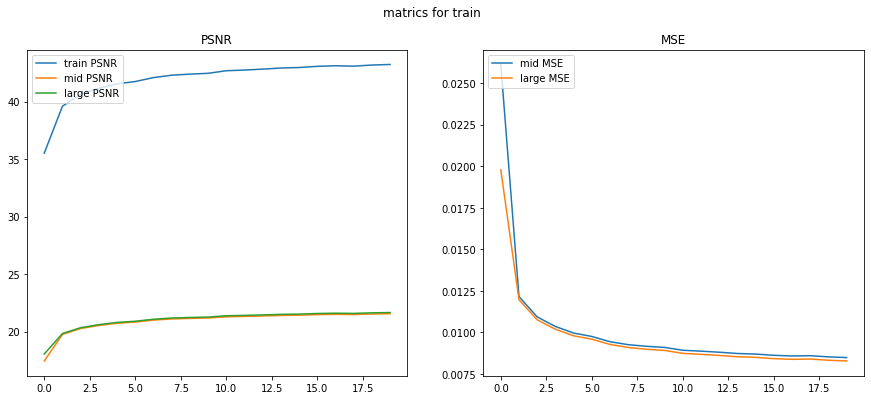

train mean MSE for mid image: 0.010
train mean MSE for large image: 0.010
train mean PSNR for mid image: 20.924
train mean PSNR for large image: 21.036
train mean PSNR: 41.960


In [ ]:
resnet_fe = train_model(resnet_fe, epochs=20)

mean PSNR for mid images: 20.615
mean PSNR for large images: 20.745

mean MSE for mid images: 0.010
mean MSE for large images: 0.010



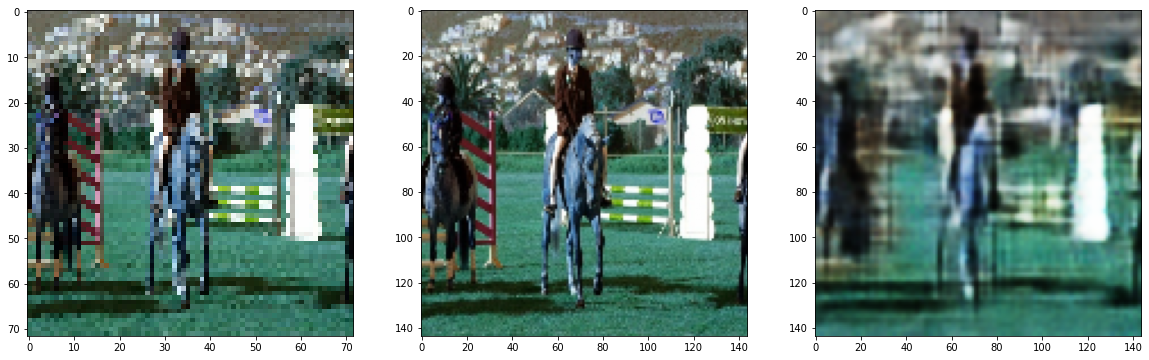

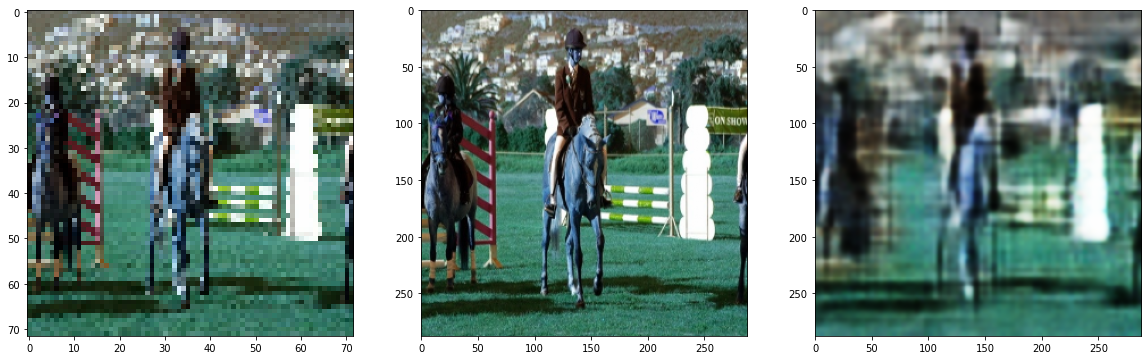

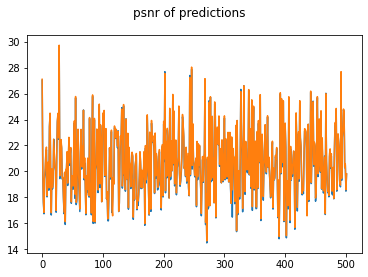

In [ ]:
predict_and_show_results(resnet_fe, x_test, 8)